## NHL Season Playoff Outcome Logistic Regression

### Description

The following classification analysis seeks to predict failed playoff outcomes with team season adjusted wins **(wins + (ties / 2))** above or below the average adjusted wins of any given season for years 1983 - 2021 by the following independent variables:

* **Penalty kill percentage**
* **Shooting percentage**
* **Failed shots per game**
* **Save percentage**
* **Saves per game**

The goal of the analysis is to build a model that can use these five independent features to predict playoff outcomes.

By understanding the mentioned features above, a clearer understanding of the path to **not making** versus **making** the playoffs should be gained. 

In [12]:
# Import libraries
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')
import numpy as np

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

from Preprocessing_Functions import *
from Classification_Metrics_Functions import *

from pickle import dump 
from pickle import load

### Data Preprocessing

In [13]:
# Import the data frame from the logistic regression EDA
nhl_df = pd.read_csv('Data/NHL_1983_2021_Playoff_Data_Removed_Outliers.csv')

# Print Data Summary
nhl_df.info()
nhl_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 922 entries, 0 to 921
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   penalty_kill_percentage  922 non-null    float64
 1   shooting_pctg            922 non-null    float64
 2   save_pctg                922 non-null    float64
 3   failed_shots_per_game    922 non-null    float64
 4   saves_per_game           922 non-null    float64
 5   missed_playoffs          922 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 43.3 KB


,penalty_kill_percentage,shooting_pctg,save_pctg,failed_shots_per_game,saves_per_game,missed_playoffs
0,75.3,10.9,86.3,23.511263,27.616000,1
1,81.5,14.7,89.9,25.824575,30.015362,0
2,78.1,12.3,88.0,27.965338,27.764000,0
3,76.6,11.9,87.3,32.376750,25.011450,0
4,76.0,11.2,86.6,25.163700,31.479100,1


The data from the logistic regression EDA analysis is imported.

In [14]:
# Check the frequency of missed_playoffs
failed_playoff_flag_strata = nhl_df['missed_playoffs'].value_counts() / len(nhl_df)
print(failed_playoff_flag_strata)

0    0.583514
1    0.416486
Name: missed_playoffs, dtype: float64


The frequencies for the missed_playoffs instances are observed.

In [15]:
# Split the data into an 80/20 train and test stratified split by missed_playoffs frequency
split = StratifiedShuffleSplit(
    n_splits = 1, 
    test_size = 0.3, 
    random_state = 42
) 

for train_index, test_index in split.split(nhl_df, nhl_df['missed_playoffs']):
    strat_train_set = nhl_df.loc[train_index] 
    strat_test_set = nhl_df.loc[test_index]

The data is at a 70/30 stratified train and test split. This will allow the train and test data to retain the proportion of playoff outcomes (missed_playoffs).

Splitting the data through stratified splits will allow for a more robust model.


train and test data season type percent of data:


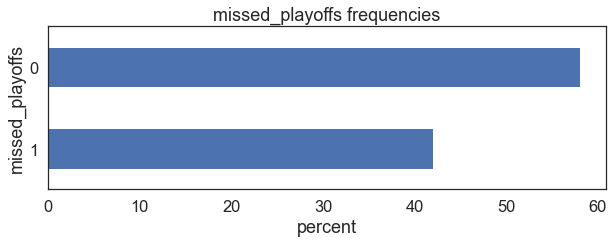

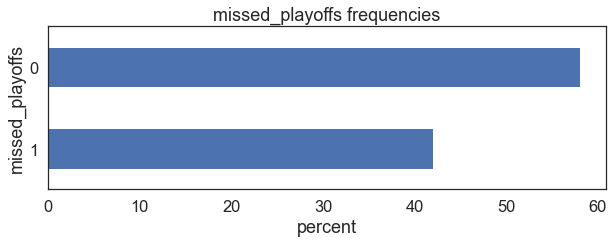

In [16]:
# Check the train and test data missed_playoffs frequency to test the stratified data split
print('\n' + 'train and test data season type percent of data:')

train_temp = strat_train_set[['missed_playoffs']].astype(str)
test_temp = strat_test_set[['missed_playoffs']].astype(str)

cat_univariate_freq(
    df = train_temp, 
    length = 3, 
    width = 10, 
    col_start = 0, 
    col_end = 1, 
    font = 1.5
)

cat_univariate_freq(
    df = test_temp, 
    length = 3, 
    width = 10, 
    col_start = 0, 
    col_end = 1, 
    font = 1.5
)

The stratified train and test split playoff outcome proportions are visualized through the missed_playoffs for train and test data.

We can see that it is more likely for teams to make the playoffs than miss out through the visualization. Creating this model should help narrow the focus on why teams miss the playoffs and avoid this path when organizing their future or current campaigns.

In [17]:
# Slpit the train set into X_train and y_train
X_train = strat_train_set[strat_train_set.columns[1:len(strat_train_set.columns)-1]].reset_index(drop = True)
y_train = strat_train_set[['missed_playoffs']].reset_index(drop = True)

print('\n','<------------------------------------ Train Data ------------------------------------>'.center(110),'\n')
print(X_train.info())
display(X_train.head())
print(y_train.info())
display(y_train.head())

# Slpit the test set into X_test and y_test
X_test = strat_test_set[strat_test_set.columns[1:len(strat_test_set.columns)-1]].reset_index(drop = True)
y_test = strat_test_set[['missed_playoffs']].reset_index(drop = True)

print('\n','<------------------------------------ Test Data ------------------------------------>'.center(110),'\n')
print(X_test.info())
display(X_test.head())
print(y_test.info())
display(y_test.head())


             <------------------------------------ Train Data ------------------------------------>             

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 645 entries, 0 to 644
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   shooting_pctg          645 non-null    float64
 1   save_pctg              645 non-null    float64
 2   failed_shots_per_game  645 non-null    float64
 3   saves_per_game         645 non-null    float64
dtypes: float64(4)
memory usage: 20.3 KB
None


,shooting_pctg,save_pctg,failed_shots_per_game,saves_per_game
0,8.6,90.6,31.454944,25.887319
1,9.4,91.0,27.091574,27.655082
2,10.9,86.8,27.052988,26.723550
3,8.0,90.2,27.498984,24.871026
4,9.9,91.0,24.502785,23.981867


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 645 entries, 0 to 644
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   missed_playoffs  645 non-null    int64
dtypes: int64(1)
memory usage: 5.2 KB
None


,missed_playoffs
0,0
1,1
2,1
3,1
4,0



             <------------------------------------ Test Data ------------------------------------>              

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277 entries, 0 to 276
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   shooting_pctg          277 non-null    float64
 1   save_pctg              277 non-null    float64
 2   failed_shots_per_game  277 non-null    float64
 3   saves_per_game         277 non-null    float64
dtypes: float64(4)
memory usage: 8.8 KB
None


,shooting_pctg,save_pctg,failed_shots_per_game,saves_per_game
0,9.8,90.4,25.475998,25.741942
1,9.5,91.1,26.609172,23.241614
2,10.0,89.9,23.718330,23.472710
3,7.1,89.7,27.348831,25.509783
4,9.9,91.3,27.887031,24.038651


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277 entries, 0 to 276
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   missed_playoffs  277 non-null    int64
dtypes: int64(1)
memory usage: 2.3 KB
None


,missed_playoffs
0,0
1,0
2,1
3,1
4,0


The train and test data are split so X and y values are set to their own data frames.

penalty_kill_percentage is removed from the data sets due to the feature not being statistically significant at p < 0.05.

In [18]:
k_fold = StratifiedShuffleSplit(
    n_splits = 10, 
    random_state = 0, 
    test_size = 0.20, 
    train_size = None
)

print('\n' + 'Train and Test Shuffled K-Fold Data:' + '\n')
for train_index, test_index in k_fold.split(X_train,  y_train['missed_playoffs']):
    print("train index:", train_index[:10], "length:", len(train_index))
    print("test index:", test_index[:10], "length:", len(test_index))
    print('')


Train and Test Shuffled K-Fold Data:

train index: [ 91 319 338 477 115 601 313 273 533 643] length: 516
test index: [ 89 409 509 573 572 497   5 357 579 577] length: 129

train index: [484 180 203 285 636   7  70 272 129 634] length: 516
test index: [ 91  75 540 619 234 184 300 430 445  58] length: 129

train index: [535 581 595  69 183 148 590 237 375 509] length: 516
test index: [446 624 292  11 116   7 596 464 349 501] length: 129

train index: [ 22 375 305 239 490  71 267 592 318 551] length: 516
test index: [163 556 218 501 410 504 115 220 319 350] length: 129

train index: [348 292 383 302 626 301 119 458 565  83] length: 516
test index: [196 500 602 389 424  62 417 459 474 637] length: 129

train index: [159 426 356 504 574 383 287 580 503 409] length: 516
test index: [524 571 191 351 558 564   1 482 188 402] length: 129

train index: [336 337 166 352  80 495 438 546 253 596] length: 516
test index: [539  56 588  12 230 369 227 490 161 268] length: 129

train index: [502 215 2

In [19]:
# GridSearchCv for hyper paramters
penalty = [
    'l1', 
    'l2',
    'elasticnet',  
    'None'
]

C = np.geomspace(
    start = 10,
    stop = 100, 
    num = 10
)

solver = ['liblinear', 'lbfgs']

params = {
    'penalty': penalty,
    'C': C,
    'solver': solver
}

grid = GridSearchCV(
    LogisticRegression(), 
    params, 
    cv = k_fold, 
    scoring = 'f1'
)

grid.fit(X_train, y_train)
grid.best_score_, grid.best_params_

(0.8576082489502157, {'C': 10.0, 'penalty': 'l2', 'solver': 'lbfgs'})


test model f-fold metrics:



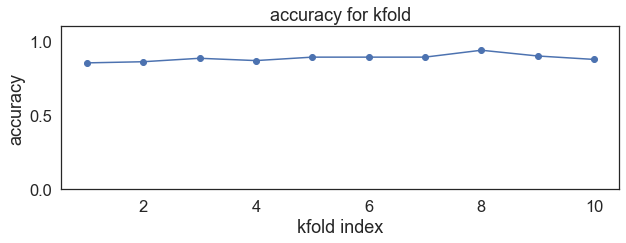

accuracy k-fold cross validation:                  ................0.89
accuracy std:                                      ................0.02


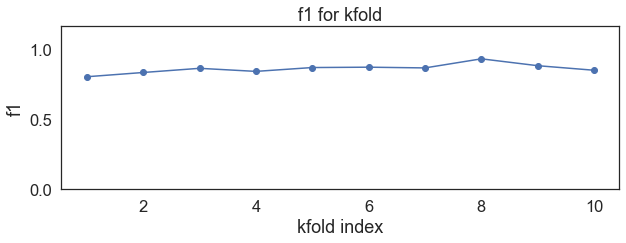



f1 k-fold cross validation:                        ................0.86
f1 std:                                            ................0.03


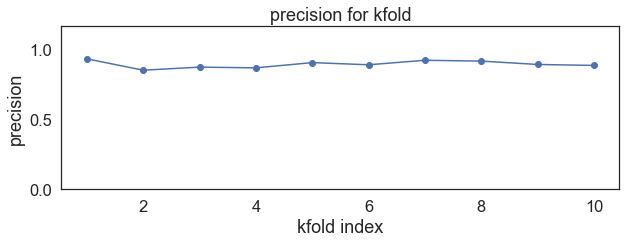



precision k-fold cross validation:                 ................0.89
precision std:                                     ................0.02


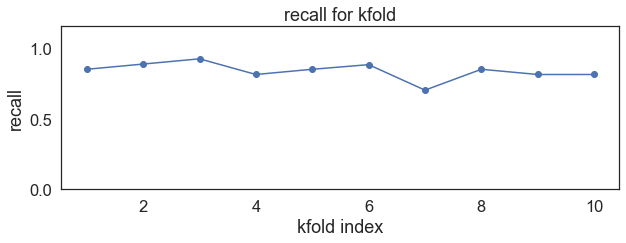



recall k-fold cross validation:                    ................0.84
recall std:                                        ................0.06




In [20]:
# Test metrics across the k-folds
logit_regressor = LogisticRegression(
    penalty = grid.best_params_.get('penalty'),
    C = grid.best_params_.get('C'),
    solver = grid.best_params_.get('solver')
)

classification_cross_val_splits(
    classifier = logit_regressor, 
    X_train = X_train, 
    y_train = y_train, 
    cv = k_fold,
    font = 1.5
)

Above are the k-fold cross validation results.

The model performance appears to deliver strong and consistent results on the train data. 

### Model Training and Testing

#### Model Training, Evaluation, and Interpretation

In [21]:
# Fit and train the logistic regression model
logit_regressor = LogisticRegression()
logit_regressor.fit(X_train,  y_train)

# Predict with X_train data
y_pred_train = logit_regressor.predict(X_train)

# Create a data frame from the predicted results
y_pred_train = pd.DataFrame(y_pred_train, columns = ['predictions_train'])

# Creates a data frame from the prediction probabilities
proba = logit_regressor.predict_proba(X_train)
proba = pd.DataFrame(proba, columns = ['0', 'predicted_proba'])

proba = proba[['predicted_proba']]

# Create a separate data frame from y_train
playoff_flag = y_train.reset_index(drop = True).reset_index(drop = True)

# Concatenate all three data frames
data_frames = [
    playoff_flag, 
    y_pred_train, 
    proba
]

results = pd.concat(data_frames, axis = 1)

# Print data summary
print('\n')
results.info()
display(results.head())

# Observe features for significance
print('\n')
logit_summary(X = X_train, y = y_train)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 645 entries, 0 to 644
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   missed_playoffs    645 non-null    int64  
 1   predictions_train  645 non-null    int64  
 2   predicted_proba    645 non-null    float64
dtypes: float64(1), int64(2)
memory usage: 15.2 KB


,missed_playoffs,predictions_train,predicted_proba
0,0,0,0.094225
1,1,0,0.385686
2,1,1,0.935816
3,1,1,0.866471
4,0,0,0.065419




Optimization terminated successfully.
         Current function value: 0.277919
         Iterations 8


<class 'statsmodels.iolib.summary2.Summary'>
"""
                             Results: Logit
=========================================================================
Model:                 Logit              Pseudo R-squared:   0.591      
Dependent Variable:    missed_playoffs    AIC:                368.5153   
Date:                  2022-06-28 11:07   BIC:                390.8615   
No. Observations:      645                Log-Likelihood:     -179.26    
Df Model:              4                  LL-Null:            -438.16    
Df Residuals:          640                LLR p-value:        9.4058e-111
Converged:             1.0000             Scale:              1.0000     
No. Iterations:        8.0000                                            
-------------------------------------------------------------------------
                       Coef.   Std.Err.    z     P>|z|   [0.025   0.975] 
-------------------------------------------------------------------------
const                 193.5250  17.3805  11.1346 0.0000 159.4599 227.5901
shooting_pctg          -2.5531   0.2134 -11.9615 0.0000  -2.9714  -2.1347
save_pctg              -1.8934   0.1740 -10.8822 0.0000  -2.2344  -1.5524
failed_shots_per_game  -0.7448   0.0874  -8.5179 0.0000  -0.9162  -0.5734
saves_per_game          0.8121   0.0827   9.8221 0.0000   0.6501   0.9742
=========================================================================

"""

The model is trained to predict missed_playoffs output.

In [22]:
# Adjust prediction threshold
proba_threshold = 0.515649

results['predictions_train'] = np.where(
    results['predicted_proba'] >= proba_threshold,
    1, 0
)

# Print data summary
print('\n')
results.info()
results.head()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 645 entries, 0 to 644
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   missed_playoffs    645 non-null    int64  
 1   predictions_train  645 non-null    int32  
 2   predicted_proba    645 non-null    float64
dtypes: float64(1), int32(1), int64(1)
memory usage: 12.7 KB


,missed_playoffs,predictions_train,predicted_proba
0,0,0,0.094225
1,1,0,0.385686
2,1,1,0.935816
3,1,1,0.866471
4,0,0,0.065419


Because the as shown below in the bootstrap f1 score testing, 0.515649 is the optimal threshold for the model to achieve the best f1 score.



Pairs:                              ..............101144
Conc:                               ...............96144
Disc:                               ................5000
Tied:                               ...................0


Concordance:                        ................0.95
Discordance:                        ................0.05
Tied:                               .................0.0


AUC:                                ................0.95




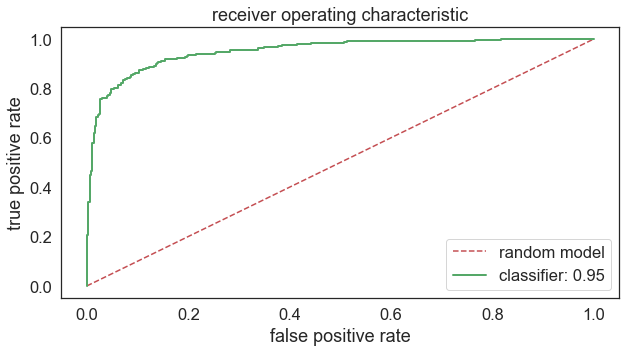



confussion matrix:



,1,0
1,226,31
0,43,345




Accuracy:                                                                   ................0.89
Precision (tp / (tp + fp)):                                                 ................0.88
Recall (tp / (tp + fn)):                                                    ................0.84
F1 ((2 * (precision * recall)) / (precision + recall)):                     ................0.86
False Positive Rate (fp / (fp + tn))                                        ................0.08
True Positive Rate (tp / (tp + fn)):                                        ................0.84
Increase in TPR / FPR (true_positive_rate / false_positive_rate):           ................10.5




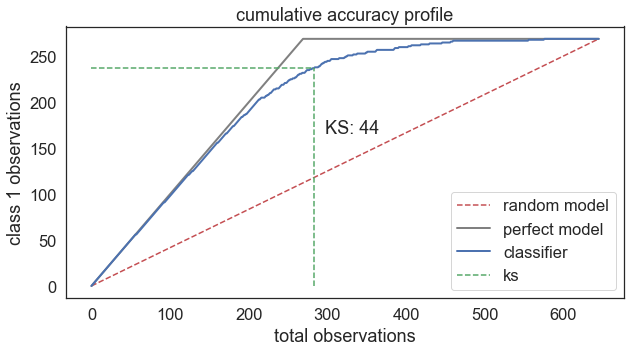

,bin,count_of_rows,missed_playoffs,model_percent,random_percent,model_cumm_percent,random_cumm_percent,ks
0,0.0,0,0,0.00,0,0.00,0,0.00
1,1.0,64,63,23.42,10,23.42,10,13.42
2,2.0,64,62,23.05,10,46.47,20,26.47
3,3.0,64,59,21.93,10,68.40,30,38.40
4,4.0,64,42,15.61,10,84.01,40,44.01
5,5.0,64,22,8.18,10,92.19,50,42.19
6,6.0,64,9,3.35,10,95.54,60,35.54
7,7.0,64,8,2.97,10,98.51,70,28.51
8,8.0,64,2,0.74,10,99.25,80,19.25
9,9.0,64,2,0.74,10,99.99,90,9.99


,bin,min_predicted_proba_per_bin,max_predicted_proba_per_bin,mean_predicted_proba_per_bin,median_predicted_proba_per_bin
0,1.0,0.978359,0.999995,0.992816,0.994493
1,2.0,0.922856,0.978229,0.956956,0.962120
2,3.0,0.804835,0.920826,0.861654,0.859914
3,4.0,0.522263,0.802567,0.659216,0.659014
4,5.0,0.279731,0.515649,0.373525,0.358989
5,6.0,0.133731,0.274322,0.202041,0.200660
6,7.0,0.067620,0.132353,0.098760,0.099167
7,8.0,0.024113,0.066618,0.043465,0.043044
8,9.0,0.004939,0.023430,0.012776,0.011924
9,10.0,0.000003,0.004726,0.001771,0.001433


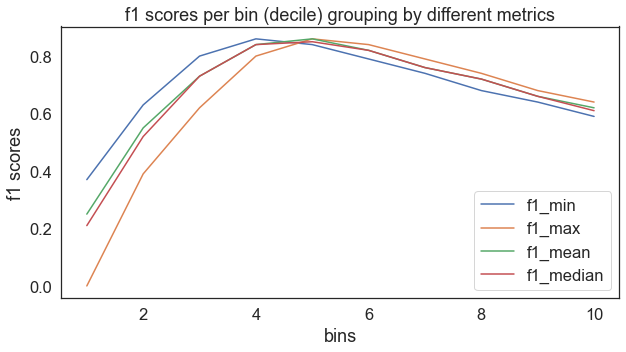

,bin,threshold_min,f1_min,threshold_max,f1_max,threshold_mean,f1_mean,theshold_median,f1_median
0,1.0,0.978359,0.37,0.999995,0.00,0.992816,0.25,0.994493,0.21
1,2.0,0.922856,0.63,0.978229,0.39,0.956956,0.55,0.962120,0.52
2,3.0,0.804835,0.80,0.920826,0.62,0.861654,0.73,0.859914,0.73
3,4.0,0.522263,0.86,0.802567,0.80,0.659216,0.84,0.659014,0.84
4,5.0,0.279731,0.84,0.515649,0.86,0.373525,0.86,0.358989,0.85
5,6.0,0.133731,0.79,0.274322,0.84,0.202041,0.82,0.200660,0.82
6,7.0,0.067620,0.74,0.132353,0.79,0.098760,0.76,0.099167,0.76
7,8.0,0.024113,0.68,0.066618,0.74,0.043465,0.72,0.043044,0.72
8,9.0,0.004939,0.64,0.023430,0.68,0.012776,0.66,0.011924,0.66
9,10.0,0.000003,0.59,0.004726,0.64,0.001771,0.62,0.001433,0.61


In [23]:
# Train results
train_cap_auc = cap_auc(
    model = logit_regressor, 
    df = results, 
    target = 'missed_playoffs', 
    y = playoff_flag, 
    y_pred = results[['predictions_train']], 
    y_score = proba, 
    X = X_train, 
    length = 5, 
    width = 10, 
    ks = 44,
    text = 'KS: 44',
    font = 1.5
)

display(train_cap_auc)
print('\n')

# Bootstrap f1 results
boostrap_f1(
    cap_threshold_df = train_cap_auc,
    x_axis = 'bin',
    results_df = results, 
    real_results_col = 'missed_playoffs', 
    pred_col = 'predictions_train', 
    pred_proba_col = 'predicted_proba',
    length = 5,
    width = 10,
    font = 1.5
)

The train model shows strong results. 

Notable observations:

1) **Concordance - 0.95** - The model probability thresholds are functioning efficiently. For every pair of positive and negative predictions, 95% of the time, positive predictions have higher probabilities than negative predictions.<br><br>

2) **Area Under the Curve (AUC) 0.95** - Being similar to **Concordance**, AUC is Concordance + (tied output pairs * 0.5). Because the model contains no tied pairs when calculating Concordance, AUC comes out to the same value. The curve itself shows that a 90% true positive rate will produce a 12% false positive rate.<br><br>

3) **F1 - 0.86** - This shows that the model is working to make predictions based on the variance of predictors. The model is not making predictions full of positives and false positives or negatives and false negatives to attain high accuracy. F1 (harmonic mean of precision and recall) describes that out of all positives predicted, 0.84 are correct (precision), and out of all positive outcomes in the data, 0.89 were predicted by the model correct (recall).<br><br>

4) **Kolmogorov-Smirnov Measure (ks)** - shows that the model predicts 84% of the data's true positives in the first four deciles of the data. The difference between the model and what a random model predicts is ks (84% - 40% = 44%). To rephrase, the model improves prediction from the random base by 2.1 times, peaking at the 4th decile of the data displaying the model's efficiency in filtering for true positive predictions.<br><br>

#### Model Testing, Evaluation, and Interpretation

In [24]:
# Predict with X_test data
y_pred_test = logit_regressor.predict(X_test)

# Create a data frame from the predicted results
y_pred_test = pd.DataFrame(y_pred_test, columns = ['predictions_test'])

# Creates a data frame from the prediction probabilities
proba = logit_regressor.predict_proba(X_test)

proba = pd.DataFrame(proba, columns = ['0', 'predicted_proba'])

proba = proba[['predicted_proba']]

# Create a separate data frame from y_test
playoff_flag = y_test.reset_index(drop = True).reset_index(drop = True)

# Concatenate all three data frames
data_frames = [
    playoff_flag, 
    y_pred_test, 
    proba
]

results = pd.concat(data_frames, axis = 1)

# Print data summary
print('\n')
results.info()
results.head()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277 entries, 0 to 276
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   missed_playoffs   277 non-null    int64  
 1   predictions_test  277 non-null    int64  
 2   predicted_proba   277 non-null    float64
dtypes: float64(1), int64(2)
memory usage: 6.6 KB


,missed_playoffs,predictions_test,predicted_proba
0,0,0,0.332934
1,0,0,0.019364
2,1,0,0.310740
3,1,1,0.995915
4,0,0,0.003998


Using the test data, the model is used to predict the missed_playoffs.

In [25]:
# Adjust prediction threshold
results['predictions_test'] = np.where(
    results['predicted_proba'] >= proba_threshold,
    1, 0
)

# Print data summary
print('\n')
results.info()
results.head()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277 entries, 0 to 276
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   missed_playoffs   277 non-null    int64  
 1   predictions_test  277 non-null    int32  
 2   predicted_proba   277 non-null    float64
dtypes: float64(1), int32(1), int64(1)
memory usage: 5.5 KB


,missed_playoffs,predictions_test,predicted_proba
0,0,0,0.332934
1,0,0,0.019364
2,1,0,0.310740
3,1,1,0.995915
4,0,0,0.003998


The same threshold of 0.515649 is used for the test set.



Pairs:                              ...............18630
Conc:                               ...............16854
Disc:                               ................1776
Tied:                               ...................0


Concordance:                        .................0.9
Discordance:                        .................0.1
Tied:                               .................0.0


AUC:                                .................0.9




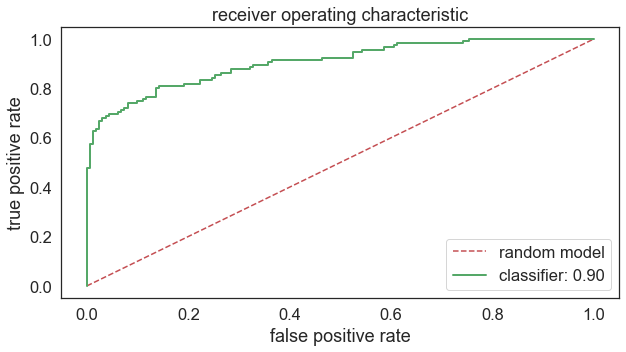



confussion matrix:



,1,0
1,83,13
0,32,149




Accuracy:                                                                   ................0.84
Precision (tp / (tp + fp)):                                                 ................0.86
Recall (tp / (tp + fn)):                                                    ................0.72
F1 ((2 * (precision * recall)) / (precision + recall)):                     ................0.78
False Positive Rate (fp / (fp + tn))                                        ................0.08
True Positive Rate (tp / (tp + fn)):                                        ................0.72
Increase in TPR / FPR (true_positive_rate / false_positive_rate):           .................9.0




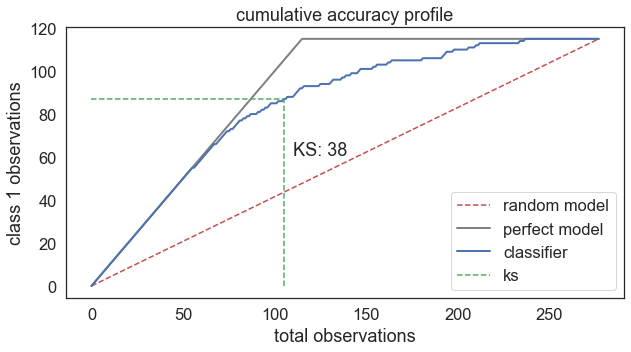

,bin,count_of_rows,missed_playoffs,model_percent,random_percent,model_cumm_percent,random_cumm_percent,ks
0,0.0,0,0,0.00,0,0.00,0,0.00
1,1.0,28,28,24.35,10,24.35,10,14.35
2,2.0,28,27,23.48,10,47.83,20,27.83
3,3.0,28,23,20.00,10,67.83,30,37.83
4,4.0,28,12,10.43,10,78.26,40,38.26
5,5.0,28,8,6.96,10,85.22,50,35.22
6,6.0,28,7,6.09,10,91.31,60,31.31
7,7.0,28,4,3.48,10,94.79,70,24.79
8,8.0,28,4,3.48,10,98.27,80,18.27
9,9.0,28,2,1.74,10,100.01,90,10.01


,bin,min_predicted_proba_per_bin,max_predicted_proba_per_bin,mean_predicted_proba_per_bin,median_predicted_proba_per_bin
0,1.0,0.983374,0.999938,0.993785,0.995861
1,2.0,0.882196,0.982688,0.944811,0.950178
2,3.0,0.643199,0.880801,0.789986,0.774297
3,4.0,0.418402,0.637404,0.514423,0.497932
4,5.0,0.266127,0.413774,0.337110,0.334556
5,6.0,0.163047,0.265433,0.206213,0.207990
6,7.0,0.075111,0.158137,0.118400,0.127299
7,8.0,0.030141,0.067647,0.043750,0.038552
8,9.0,0.005931,0.027606,0.015362,0.013890
9,10.0,0.000004,0.005790,0.002283,0.001865


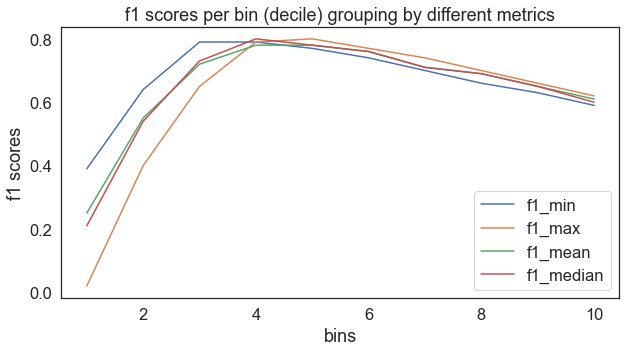

,bin,threshold_min,f1_min,threshold_max,f1_max,threshold_mean,f1_mean,theshold_median,f1_median
0,1.0,0.983374,0.39,0.999938,0.02,0.993785,0.25,0.995861,0.21
1,2.0,0.882196,0.64,0.982688,0.40,0.944811,0.55,0.950178,0.54
2,3.0,0.643199,0.79,0.880801,0.65,0.789986,0.72,0.774297,0.73
3,4.0,0.418402,0.79,0.637404,0.79,0.514423,0.78,0.497932,0.80
4,5.0,0.266127,0.77,0.413774,0.80,0.337110,0.78,0.334556,0.78
5,6.0,0.163047,0.74,0.265433,0.77,0.206213,0.76,0.207990,0.76
6,7.0,0.075111,0.70,0.158137,0.74,0.118400,0.71,0.127299,0.71
7,8.0,0.030141,0.66,0.067647,0.70,0.043750,0.69,0.038552,0.69
8,9.0,0.005931,0.63,0.027606,0.66,0.015362,0.65,0.013890,0.65
9,10.0,0.000004,0.59,0.005790,0.62,0.002283,0.61,0.001865,0.60


In [26]:
# Test results
test_cap_auc = cap_auc(
    model = logit_regressor, 
    df = results, 
    target = 'missed_playoffs', 
    y = playoff_flag, 
    y_pred = results[['predictions_test']],
    y_score = proba, 
    X = X_test,
    length = 5, 
    width = 10, 
    ks = 38, 
    text = 'KS: 38',
    font = 1.5
)

display(test_cap_auc)
print('\n')

# Bootstrap f1 results
boostrap_f1(
    cap_threshold_df = test_cap_auc,
    x_axis = 'bin',
    results_df = results, 
    real_results_col = 'missed_playoffs', 
    pred_col = 'predictions_test', 
    pred_proba_col = 'predicted_proba',
    length = 5,
    width = 10,
    font = 1.5
)

The model shows strong results on the test data. The results are slightly lower, however, this is to be expected on the test data.

Notable observations:

1) **Concordance** - 0.90 <br>

2) **Area Under the Curve (AUC)** - 0.90<br>

3) **F1** - 0.78<br>

4) **Kolmogorov-Smirnov Measure (ks)** - 38% at the 4th decile, a cumulative percentage 1.96 (78.26% (model) / 40% (random model)) times greater than a random model.<br>

### Model Finalization

In [28]:
# Set X values
X = nhl_df[X_train.columns]

# Set y values
y = nhl_df[['missed_playoffs']]

# Print data results
print(X.info())
display(X.head())
print(y.info())
display(y.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 922 entries, 0 to 921
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   shooting_pctg          922 non-null    float64
 1   save_pctg              922 non-null    float64
 2   failed_shots_per_game  922 non-null    float64
 3   saves_per_game         922 non-null    float64
dtypes: float64(4)
memory usage: 28.9 KB
None


,shooting_pctg,save_pctg,failed_shots_per_game,saves_per_game
0,10.9,86.3,23.511263,27.616000
1,14.7,89.9,25.824575,30.015362
2,12.3,88.0,27.965338,27.764000
3,11.9,87.3,32.376750,25.011450
4,11.2,86.6,25.163700,31.479100


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 922 entries, 0 to 921
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   missed_playoffs  922 non-null    int64
dtypes: int64(1)
memory usage: 7.3 KB
None


,missed_playoffs
0,1
1,0
2,0
3,0
4,1


Create an X and y data frame for the entire data set.

In [29]:
# Fit and train the logistic regression model
logit_regressor = LogisticRegression(
    penalty = grid.best_params_.get('penalty'),
    C = grid.best_params_.get('C'),
    solver = grid.best_params_.get('solver')
)

# Scale X values (converts X values to numpy 2D array)
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

# Convert y values to numpy 1D array
y = y.iloc[:,:].values
y = y.reshape((-1,))

# Fit classifier
logit_regressor.fit(X, y)

LogisticRegression(C=10.0)

Train model on entire data set to finalize the model.

In [30]:
# save the model
dump(logit_regressor, open('Classification_Models/NHL_Playoffs_Logistic_Regression_Model.pkl', 'wb'))

# save the scaler
dump(scaler, open('Classification_Models/Scaler_Logi.pkl', 'wb'))

Save logistic regression model.

In [31]:
# load the model
model = load(open('Classification_Models/NHL_Playoffs_Logistic_Regression_Model.pkl', 'rb'))

# load the scaler
scaler = load(open('Classification_Models/Scaler_Logi.pkl', 'rb'))

Load logistic regression model.

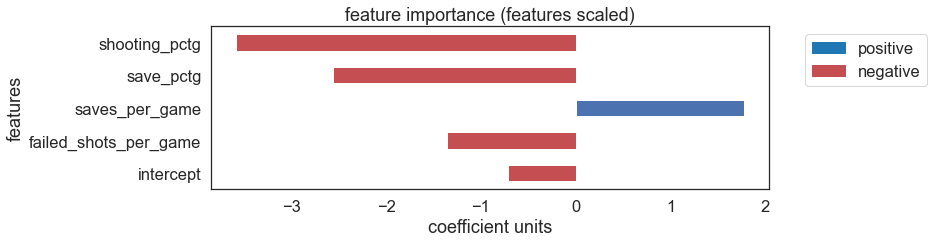

,features,coef,positive
4,shooting_pctg,-3.576889,False
3,save_pctg,-2.562234,False
2,saves_per_game,1.772241,True
1,failed_shots_per_game,-1.351726,False
0,intercept,-0.710093,False


In [34]:
# Convert X back to a data frame
X = pd.DataFrame(X, columns = X_train.columns)

classification_feature_importance(
    model = model, 
    X_cols = X, 
    font = 1.5, 
    length = 3, 
    width = 10, 
    pos = 'b', 
    neg = 'r'
)

### Summary

seasonAdjWinsDev has proven to be an effective feature when predicting playoff contention for NHL organizations and this is shown by successfully proving a strong relationship between the independent features used in the the Linear Regression and the missing the playoffs target variable.

If teams want to make the playoffs they need to increase their seasonAdjWinsDev. To increase their seasonAdjWinsDev, teams must seek to focus on:

1) **shooting_pctg**

2) **save_pctg**

3) **saves_per_game**

4) **failed_shots_per_game**

Features are in descending order basis importance (shooting_pctg and save_pctg are interchangeably the top feature depending on the model).<br>
Features that are negative values, teams should look to increase them.<br>
Features with positive values, teams should look to decrease them.